# Reinforcement Learning

In this lab, you will have the opportunity to explore Reinforcement Learning (RL) algorithms in practice, training agents to navigate through a 2D grid world to maximize their rewards. In a sequence of tasks, you will 

1. discover the effect of randomness on RL training,
2. compare different RL algorithms trained on the same task, 
3. implement the Q-Learning algorithm
4. explore whether the task is harder to learn if the agent started in a different random position in each episode, and
5. explore different tasks by modifying the environment's reward structure

## Setup

We start by importing dependencies and setting up some functions that will be useful in completing these tasks.

### Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from grid_world import GridWorld  # Ensure the file grid_world.py is located in the same folder as this notebook.

### Environment

The class below defines the grid world environment that we've already seen in the lecture. It consists of a grid with 4 rows and 5 columns, specifying 20 environment states (one state for each grid cell). In each episode, the agent starts in state (0, 3). The cell (4, 0) is declared a terminal state, ending an episode whenever the agent transitions into that state. All state transitions yield a reward of 0 by default. The reward for transitions into two specific states are set differently, yielding a reward of 1 when an agent's action results in a transition into state (4, 0), and yielding a reward of -1 when an agent's action results in a transition into state (1, 2).

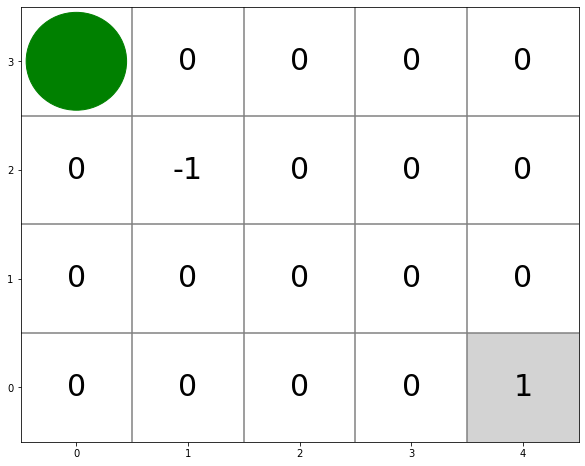

In [2]:
class ExampleGrid(GridWorld):
    
    def __init__(self):
        super().__init__(rows = 4, cols = 5, agent_start = (0, 3))
        self.update_terminal(4, 0)  # Make state (4, 0) a terminal state.
        self.update_reward(4, 0, 1)  # Make transitions into state (4, 0) yield a reward of 1.
        self.update_reward(1, 2, -1)  # Make transitions into state (1, 2) yield a reward of -1.
        
env = ExampleGrid()  # Instantiate the example grid.
env.render()  # Display the environment state(green dot), terminal states (gray shaded cells), and rewards (numbers inside cells).

### Tabular Softmax Agent

This agent class implements an explicit policy where the probability distribution over actions given a state $\pi(a|s)$ is defined as the softmax over action-specific 'logits' $z$:
\begin{equation}
\pi(a=a_i|s) = \sigma(z_{s,a}) = \frac{e^{z_{s, a_i}}}{\sum_j e^{z_{s, a_j}}}
\end{equation}

Using a tabular state representation, the policy is parameterized with a separate parameter for each state-action pair $z_{s, a}$ with state $s: (x, y) \in \mathcal{S}$ and action $a \in \mathcal{A}$.

In [3]:
class SoftmaxAgent():
    """
    A tabular agent parameterizing the logits of a softmax policy.
    
    Args:
        z (np.array): Parameters organized by [y, x, a], where (y, x) encode
        the state (as a cell in a grid world) and 'a' each possible action.
    """

    def __init__(self, z):
        self.z = z
        
    def act(self, state, epsilon):
        """
        Sample from the policy pi(a, s), where pi is defined as the 
        softmax function with parameters self.z[y, x].
        """

        x, y = state
        p = np.exp(self.z[y, x]) / np.sum(np.exp(self.z[y, x]))
        a = np.random.choice(len(p), p = p)
        return a
    
    def rollout(self, env, epsilon = 0):
        """
        Complete a full episode interacting with the environment 
        by following the current policy.
        """
        
        states, actions, rewards = [], [], []
        done = False

        s = env.reset()
        states.append(s)
        
        while not done:
            a = self.act(s, epsilon)
            s, r, done, _ = env.step(a)
            states.append(s)
            actions.append(a)
            rewards.append(r)
        
        return states, actions, rewards
    
    def render_pi(self, env, ax = None):
        """
        Display the learned policy.
        """

        if ax is None:
            fig, ax = env._create_fig()

        env.render_grid(ax)
        pi = np.exp(self.z) / np.expand_dims(np.sum(np.exp(self.z), axis = 2), axis = 2)

        for y in range(env.rows):
            for x in range(env.cols):
                # render distribution over actions
                p =  pi[y, x]
                p_max = np.max(p)
                for a in range(len(env.action_space)):
                    length = p[a] / (1e-6 + p_max) * 0.3
                    env.render_action(ax, action = env.action_space[a], agent = (x, y), length = length, hw = 0.1, hl = 0.15, ox = 0, oy = 0)

## Tasks

### 1. How does randomness affect training of REINFORCE ?

The code snippet below trains a Tabular Softmax policy with REINFORCE for 1000 rollouts (episodes) and then plots the return of each rollout. It also illustrates the trained policy and shows an example rollout from the last training step.

Write a function that repeats training 5 times and then plots mean, min and max reward after each rollout.

#### Solution Steps (implemented in the code below)
1. wrap code inside a function that returns training returns
2. call function 5 times
3. *convert all results into (5xN) numpy array (for convenience)
4. plot mean, min and max along axis=0

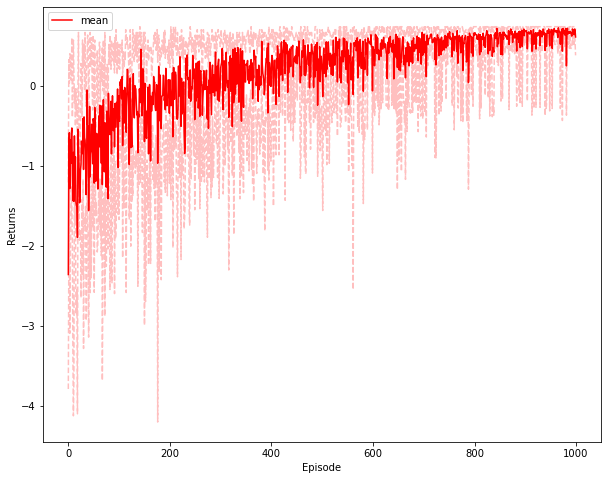

In [4]:
def train_reinforce() -> list:
    '''
    Train a Tabular Softmax policy with REINFORCE.

    Returns
    -------
    returns : training returns
    '''

    env = ExampleGrid()  # Instantiate environment.
    logits = np.ones((env.rows, env.cols, len(env.action_space)))  # Instantiate policy.
    agent = SoftmaxAgent(z = logits)
    eta = 0.01
    gamma = 0.95
    returns = []

    for i in range(1000):
        states, actions, rewards = agent.rollout(env)
        G = np.sum(rewards * gamma**np.arange(len(rewards)))  # Here, the decay gamma is omitted, implicitly assuming it to be 1.
        returns.append(G)
        z = agent.z
        dz = np.zeros_like(z)

        for t in range(len(states) - 1):
            x, y = states[t]
            a = actions[t]
            G = np.sum(rewards[t:] * gamma**np.arange(len(rewards[t:])))
            dz[y,x] -= G
            dz[y,x, a] += G

        z = agent.z + eta * dz  # Apply gradient with learning rate eta.
        agent.z = np.maximum(-6, np.minimum(6, z))  # Saturate logits to avoid distribution collapse.
    
    return returns


reinforce_returns = []

for _ in range(5):
    reinforce_returns.append(train_reinforce())

reinforce_returns = np.array(reinforce_returns)
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(np.mean(reinforce_returns, axis = 0), 'r', label = 'mean')
ax.plot(np.min(reinforce_returns, axis = 0), 'r--', alpha = 0.25)
ax.plot(np.max(reinforce_returns, axis = 0), 'r--', alpha = 0.25)
plt.xlabel('Episode')
plt.ylabel('Returns')
plt.legend()
plt.show()

## 2. How does Actor-Critic compare to REINFORCE in training performance?

The code snippet below trains a Tabular Softmax policy with Actor-Critic for 1000 rollouts (episodes) and then plots the return of each rollout. It also illustrates the trained policy and shows an example rollout from the last training step.

Train Actor-Critic 5 times and compare mean, min and max return in each rollout with the mean min and max return observed during REINFORCE training.

#### Solution Steps (implemented in the code below)
1. apply all steps from task 1. above to the code below
    1. wrap code inside a function that returns training returns
    2. call function 5 times
    3. *convert all results into (5xN) numpy array (for convenience)
    4. plot mean, min and max along axis=0
2. plot results from task 1. in the same figure

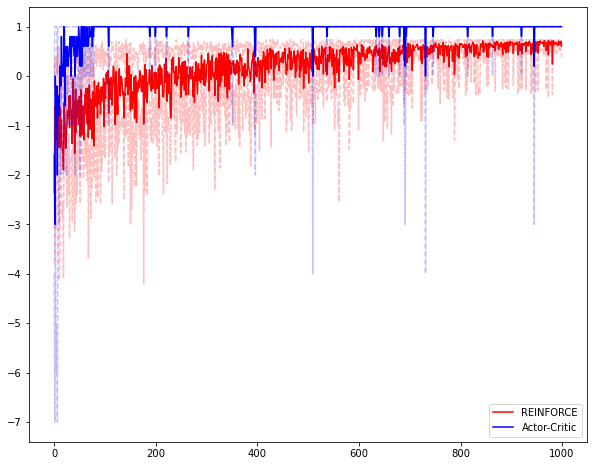

In [5]:
def train_ac():
    '''
    Train a Tabular Softmax policy with Actor-Critic.

    Returns
    -------
    returns : training returns
    '''

    env = ExampleGrid()  # Instantiate environment.
    logits = np.ones((env.rows, env.cols, len(env.action_space)))  # Instantiate policy.
    agent = SoftmaxAgent(z = logits)
    eta = 0.2
    gamma = 1
    Q = np.zeros_like(logits)  # Initialize the critic.
    returns = []

    for i in range(1000):
        states, actions, rewards = agent.rollout(env)
        G = np.sum(rewards)
        returns.append(G)
        G -= np.mean(returns)
        p = np.exp(agent.z) / np.expand_dims(np.sum(np.exp(agent.z), axis = 2), axis = 2)
        dz = np.zeros_like(agent.z)

        for t in range(len(states) - 1): 
            x, y = states[t]
            a = actions[t]
            
            # Estimate updated Q.
            x_next, y_next = states[t + 1]
            v = np.sum(Q * p, axis = 2)[y_next, x_next]
            Q[y, x, a] = rewards[t] + gamma * v
            
            # Estimate gradient,
            # Here, we scale gradients with the relevant Q-value in each step instead of using the episode return at the end.
            dz[y, x] -= Q[y, x, a]
            dz[y, x, a] += Q[y, x, a]
        
        z = 0.99*agent.z + eta * dz  # Update parameters.
        agent.z = np.maximum(-6, np.minimum(6, z))  # Saturate parameters to prevent distribution collapse.

    return returns


ac_returns = []

for _ in range(5):
    ac_returns.append(train_ac())

ac_returns = np.array(ac_returns)
fig, ax= plt.subplots(figsize=(10, 8))
ax.plot(np.mean(reinforce_returns, axis = 0), 'r', label = 'REINFORCE')
ax.plot(np.min(reinforce_returns, axis = 0), 'r--', alpha = 0.25)
ax.plot(np.max(reinforce_returns, axis = 0), 'r--', alpha = 0.25)
ax.plot(np.mean(ac_returns, axis = 0), 'b', label = 'Actor-Critic')
ax.plot(np.min(ac_returns, axis = 0), 'b--', alpha = 0.25)
ax.plot(np.max(ac_returns, axis = 0), 'b--', alpha = 0.25)
plt.legend()
plt.show()

## 3. Implement the Q-Learning algorithm


### 3.1 Action Selection

Implement the ```act``` method of the `QAgent` below to select the action with maximum Q-value. 

Amend your implementation to an $\epsilon$-greedy policy that returns a random action with probability $\epsilon$ and returns the action with maximum Q-value with probability $(1-\epsilon)$.

In [6]:
class QAgent(SoftmaxAgent):
    """
    A tabular agent parameterizing the Q-values corresponding to the policy.
    
    Args:
        q (np.array): Parameters organized by [y, x, a], where (y, x) encode
                    the state (as a cell in a grid world) and 'a' each possible action.
        
    """

    def __init__(self, q):
        self.q = q
        
    def act(self, state, epsilon = 0.1):
        """ Select the action with maximum q-value for the given state.
        
        Steps: 
            1. return the action with maximum Q-value. Assume all relevant Q-values
               are stored in self.q[y, x]. The function np.argmax returns the index 
               of the maximum value (consult the numpy documentation online for 
               examples).
               
            2. implement an epsilon-greedy policy with random exploration probability 
               passed in through the parameter "epsilon".
        
        """

        if np.random.uniform() < epsilon:
            a = np.random.randint(4)  # Number of actions hard-coded here for simplicity; could also read it from "self.q.shape[-1]".
        else:
            x, y = state
            q_s = self.q[y, x]
            a = 0  # Set "a" to the correct return value.

        return a
        
    
    def render_pi(self, env, ax = None):
        if ax is None:
            fig, ax = env._create_fig()
            
        env.render_grid(ax)

        for y in range(env.rows):
            for x in range(env.cols):
                env.render_action(ax, action = np.argmax(self.q[y, x]), agent = (x, y), length = 0.3, hw = 0.1, hl = 0.15, ox = 0, oy = 0)

### 3.2 Q-Learning Update

Implement the Q-Learning update $Q(s_t, a_t) \leftarrow r + \gamma \, \text{argmax}_j \, Q(s_{t+1}, a_j)$

In [7]:
def train_qlearning():
    env = ExampleGrid()
    Q = np.zeros((env.rows, env.cols, len(env.action_space)))
    agent = QAgent(q = Q)
    epsilon = 1
    gamma = 0.95
    returns = []

    for i in range(200):
        # Do training rollout with epsilon-greedy policy.
        states, actions, rewards = agent.rollout(env, epsilon)
        G = np.sum(rewards * gamma**np.arange(len(rewards)))
        returns.append(G)
        
        # Update Q-Table.
        for t in range(len(states) - 1):
            x, y = states[t]
            a = actions[t]
            x_next, y_next = states[t + 1]
            Q[y, x, a] = rewards[t] + gamma * np.max(Q[y_next, x_next])
        
        epsilon = max(0.05, 0.9 * epsilon)  # Decay epsilon.

    return returns

### 3.3 Evaluation

Evaluate your algorithm, training 5 times and plot mean, min and max return after each rollout

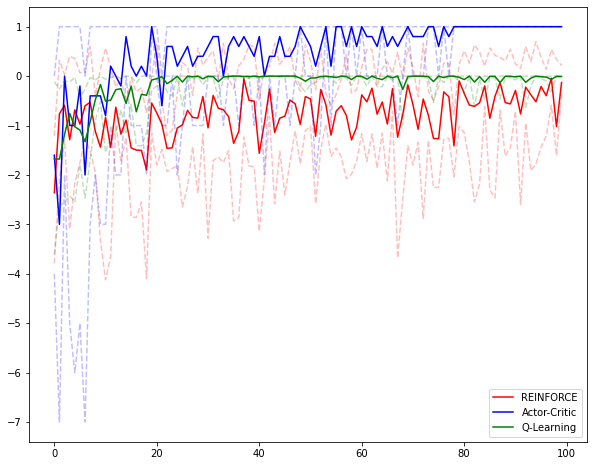

In [8]:
q_returns = []

for _ in range(5):
    q_returns.append(train_qlearning())

q_returns = np.array(q_returns)
n_steps = 100  # Number of training steps to plot.
fig, ax= plt.subplots(figsize=(10, 8))
ax.plot(np.mean(reinforce_returns, axis = 0)[:n_steps], 'r', label = 'REINFORCE')
ax.plot(np.min(reinforce_returns, axis = 0)[:n_steps], 'r--', alpha = 0.25)
ax.plot(np.max(reinforce_returns, axis = 0)[:n_steps], 'r--', alpha = 0.25)
ax.plot(np.mean(ac_returns, axis = 0)[:n_steps], 'b', label = 'Actor-Critic')
ax.plot(np.min(ac_returns, axis = 0)[:n_steps], 'b--', alpha = 0.25)
ax.plot(np.max(ac_returns, axis = 0)[:n_steps], 'b--', alpha = 0.25)
ax.plot(np.mean(q_returns, axis = 0)[:n_steps], 'g', label = 'Q-Learning')
ax.plot(np.min(q_returns, axis = 0)[:n_steps], 'g--', alpha = 0.25)
ax.plot(np.max(q_returns, axis = 0)[:n_steps], 'g--', alpha = 0.25)
plt.legend()
plt.show()

## 4. Does the task get harder to learn if the agent starts in a different random position?

Adapt the environmnet such that the the agent starts at a different (random) position in each rollout and explore the training progress of one RL algorithm. You may need to adapt the number of rollouts, the learning rate, or the exploration rate.

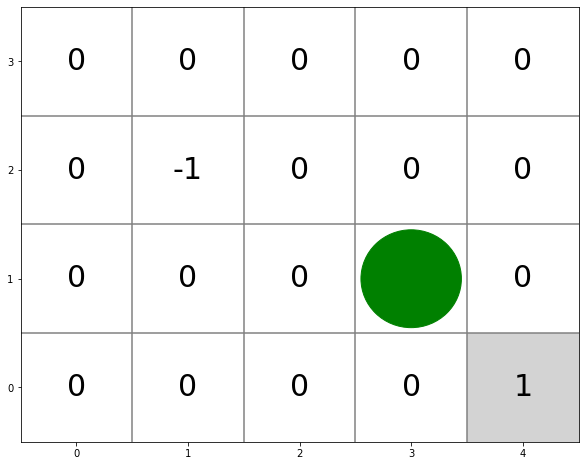

In [9]:
class ExampleGrid(GridWorld):
    
    def __init__(self):
        agent_x = np.random.randint(5)
        agent_y = np.random.randint(4)
        super().__init__(rows = 4, cols = 5, agent_start = (agent_x, agent_y))
        self.update_terminal(4, 0)  # Make state (4, 0) a terminal state.
        self.update_reward(4, 0, 1)  # Make transitions into state (4, 0) yield a reward of 1.
        self.update_reward(1, 2, -1)  # Make transitions into state (1, 2) yield a reward of -1.
        
env = ExampleGrid()  # Instantiate the example grid.
env.render()  # Display the environment state(green dot), terminal states (gray shaded cells), and rewards (numbers inside cells).

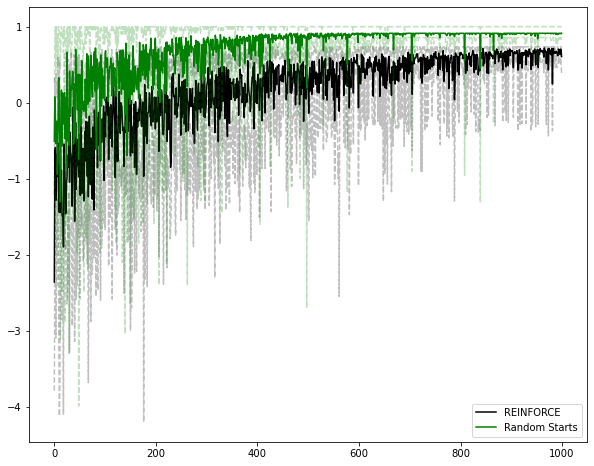

In [10]:
random_starts = []

for _ in range(5):
    random_starts.append(train_reinforce())

random_starts = np.array(random_starts)
n_steps = 1000  # Number of training steps to plot.
fig, ax= plt.subplots(figsize=(10, 8))
ax.plot(np.mean(reinforce_returns, axis = 0)[:n_steps], 'k', label = 'REINFORCE')
ax.plot(np.min(reinforce_returns, axis = 0)[:n_steps], 'k--', alpha = 0.25)
ax.plot(np.max(reinforce_returns, axis = 0)[:n_steps], 'k--', alpha = 0.25)
ax.plot(np.mean(random_starts, axis = 0)[:n_steps], 'g', label = 'Random Starts')
ax.plot(np.min(random_starts, axis = 0)[:n_steps], 'g--', alpha = 0.25)
ax.plot(np.max(random_starts, axis = 0)[:n_steps], 'g--', alpha = 0.25)
plt.legend()
plt.show()

## 5. Explore different tasks by modifying the environment's reward structure

Change the reward structure of the environment to represent a different custom task of your choice and explore the training progress of one RL algorithm, and interpret the learned policy. You may need to adapt the number of rollouts, the learning rate, or the exploration rate (epsilon).

#### Solution

This is an open-ended exercise, where you can use `self.update_reward` to change the reward for other cells in the grid and re-run their evaluation code.

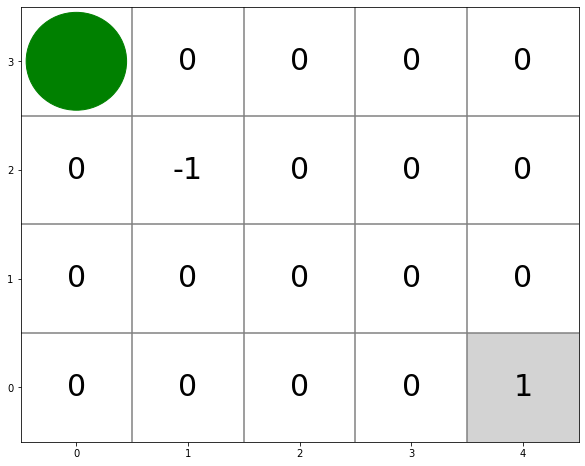

In [11]:
class ExampleGrid(GridWorld):
    
    def __init__(self):
        super().__init__(rows = 4, cols = 5, agent_start = (0, 3))
        self.update_terminal(4, 0)  # Make state (4, 0) a terminal state.
        self.update_reward(4, 0, 1)  # Make transitions into state (4, 0) yield a reward of 1.
        self.update_reward(1, 2, -1)  # Make transitions into state (1, 2) yield a reward of -1.
        
env = ExampleGrid()  # Instantiate the example grid.
env.render()  # Display the environment state(green dot), terminal states (gray shaded cells), and rewards (numbers inside cells).